In [1]:
# !pip3 install talos
# !pip3 install --upgrade --no-deps --force-reinstall git+https://github.com/autonomio/talos
# !pip3 install Keras
# !pip3 install kerasplotlib --no-deps
# !pip3 install wrangle --no-deps

In [2]:
# Basic libs
import array as array
import glob
import numpy as np
import pandas as pd
import sys
import time
from datetime import datetime, timedelta
from pathlib import Path
from pandas.plotting import scatter_matrix

# Plot libs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.patches as patches

# Model libs
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import LSTM as LSTM_keras
from numpy.random import seed
from sklearn.metrics import mean_squared_error
from keras.models import model_from_json

# Optimization Lib
import keras.metrics as metrics
from talos import Scan, Reporting
from os import listdir

# To get reproducible results:
seed_value = 1
import os

## Initialize the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Libs to set the random value 
import random
import numpy as np
import tensorflow as tf

In [3]:
# Number of minutes to aggregate the data
MINUTES = 1

# Where the test data start
TEST_INIT_DATE = datetime(2020, 12, 1).date()

# Size of the look back
LOOK_BACK = 12

# The csv station ("santa_elena" or "hawkesworth_bridge")
STATION = "santa_elena"

# Factor to multiply by MAPE in classification step
FACTOR = 10

## Reproducible Results

In [4]:
# Set the random state to "1" to get reproducible results
def reset_random_seeds():
    
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ["PYTHONHASHSEED"] = str(1)
    
    # 2. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(1)
    
    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(1)
    
    # 4. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(1)

## Pre-Processing

In [5]:
# Combines the csvs creating a DataFrame with all data (regression)
def read_data(path):
    df_all = None

    # Show all csv ending with _wtlv1 in all dirs inside this path
    for f in Path(path).rglob('*_wtlv1*.csv'):
        print(f)
    
        # Ignores other spreadsheets that are not STATION
        if not STATION in str(f):
            continue
    
        # Get the filename, without the path
        station = os.path.basename(f).split('_wtlv1')[0]
    
        # datetime and update_at are combined as one date column
        _df = pd.read_csv(f, parse_dates=["datetime", "updated_at"])
        _df['station'] = station
    
        if df_all is None:
            df_all = _df
        else:
            df_all = pd.concat([df_all, _df], ignore_index=True)
        
    # Remove updated_at and variable_id columns 
    df_all.drop(columns=['updated_at', 'variable_id'], inplace=True)
    
    # Remove duplicates rows (by datetime)
    df_all.drop_duplicates(subset=["datetime"], keep="last", inplace=True)
      
    # Sort the dataframe and remove the index
    df_all.set_index("datetime", inplace=True)
    df_all.sort_index(inplace=True)
    df_all.reset_index(inplace=True)
        
    return(df_all)

In [6]:
# Read only the "anomaly_name" csv (classification)
def read_anomaly_data(anomaly_name, path):
    
    data = pd.read_csv("{}/artificial-{}-anomaly.csv".format(path, anomaly_name))

    # Convert the string dates to datetime
    data["datetime"] = pd.to_datetime(data["datetime"], format="%Y-%m-%dT%H:%M:%S", errors='coerce')
    
    return(data)

In [7]:
# Groups the data by a number of minutes
def group_by(raw_data, minutes):
    
    # Group by minutes, aggregating with "sum"
    df_aggregated = raw_data.groupby([pd.Grouper(key="datetime", freq=f"{minutes}min"), "station_id"]).sum()
    df_aggregated.reset_index(inplace=True)
    
     # Define "datetime" as index
    df_aggregated = df_aggregated.set_index('datetime')
    
    return(df_aggregated)

In [8]:
# Gets the "measured" time series and transform it in a supervised problem
## If the serie is: [1, 2, 3, 4, 5, 6] and the look_back is 3
## The data: [1, 2, 3], [2, 3, 4], [3, 4, 5] 
## The labels: 4, 5 and 6
def create_supervised_data(original_data, look_back):

    new_data = original_data.copy()

    # Organize the data with look back
    ## Features (remove first NaN columns)
    for shift in range(look_back, 0, -1):
        new_data[f"shift_{look_back-shift}"] = original_data["measured"].shift(periods=shift).iloc[look_back:]

    ## Labels
    new_data["labels"] = original_data["measured"]
    new_data = new_data.iloc[look_back:]
    
    return(new_data)

In [9]:
# Get shift columns and labels column 
def get_columns(look_back):
    x_columns = ["shift_{}".format(shift) for shift in range(look_back)]
    y_columns = "labels"
    
    return(x_columns, y_columns)

In [10]:
# Split the data into train and test set. Train: data before the "day". Test: data after the "day"
def split_dataset(df, day, look_back):
    
    # Get columns of interest
    x_columns, y_column = get_columns(look_back)
        
    df = df.reset_index()
    
    # Get train data
    df_slice = df[df.datetime.dt.date < day] 
    X_train = df_slice[x_columns]
    y_train = df_slice[y_column]
    
    # Get test data
    df_slice = df[df.datetime.dt.date >= day] 
    X_test = df_slice[x_columns]
    y_test = df_slice[y_column]
    
    print("  Train:")
    print("    - X_train: {}".format(X_train.shape))
    print("    - y_train: {}".format(y_train.shape))
    
    print("\n  Test:")
    print("    - X_test: {}".format(X_test.shape))
    print("    - y_test: {}".format(y_test.shape))
    
    # Put in a dictionary
    train = { "data": X_train, "labels": y_train }
    test = { "data": X_test, "labels": y_test }
    
    return(train, test)

## Plots Functions

In [11]:
# Funtion that plots the expected vs predicted values
def plot_predicted_vs_expected(predicted, expected, rmse, all_datetime, start, end):

    # Get the datetime of test set
    x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
    x_axis = x_axis[start:end].strftime("%d %b %H:%M")

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d2 = pd.DataFrame({"Expected": np.asarray(expected[start:end])})

    # Creates the plot
    fig, ax = plt.subplots()
    ax.plot(x_axis, d1, label="Predicted", marker="s")
    ax.plot(x_axis, d2, label="Expected", marker="s")

    # Adds subtitle
    ax.legend()
    ax.set_ylabel("Measured")
    ax.set_xlabel("Time")

    # Shows RMSE
    plt.gcf().text(-0.01, -0.01, "RMSE = {:.4}".format(rmse), fontsize=14) 

    # Adds rotation in x axis values
    plt.xticks(rotation=70)

    # Adds title and plot it
    plt.title("LSTM Model: Expected VS Predicted")
    plt.show()

In [12]:
# Function to plot the scatter plot (predicted x expected)
def scatter_plot(predicted, expected, start, end):

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d2 = pd.DataFrame({"Expected": np.asarray(expected[start:end])})

    # Define the plot
    plt.figure(1)

    ax = plt.subplot()
    plt.scatter(x=d1.values, y=d2.values)

    # Adds subtitle
    ax.set_ylabel("Expected")
    ax.set_xlabel("Predicted")

    # Adds title and plot it
    plt.title("LSTM Model: Expected VS Predicted")
    plt.show()

In [13]:
# Funtion that plots the expected vs predicted vs mav values and draw a rectangle on anomalies
def plot_predicted_vs_expected_vs_mav(predicted, measured, mav, all_datetime, start, end, anomaly_type):

    # Get the datetime of test of
    x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
    x_axis = x_axis[start:end].strftime("%d %b %H:%M")

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Measured": np.asarray(measured[start:end])})
    d2 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d3 = pd.DataFrame({"Measured and Anomalies": np.asarray(mav[start:end])})

    # Creates the plot
    fig, ax = plt.subplots()
    ax.plot(x_axis, d1, label="Measured", marker="s")
    ax.plot(x_axis, d2, label="Predicted", marker="s")
    ax.plot(x_axis, d3, label="Measured and Anomalies", marker="s")
    
    # Draw the retangles
    for index in range(start, end):
        
        # Gets the real measured and the anomaly value (from mav array)
        measure = np.asarray(measured)[index]
        anomaly = np.asarray(mav)[index]

        # If the mesuares are different, than an anomaly exists
        if(measure != anomaly):
            
            # If the anomaly is above the measure on plot
            if(anomaly > measure):
                
                if(anomaly_type == "sv"):
                    padding = 0.01
                else:
                    padding = 0.3
                
                # Define the size of the rectangle (y axis)
                top = abs(anomaly) + padding
                bottom = measure - padding
                size = top - bottom
                
                # Creates the rectangle
                rect = patches.Rectangle((index - 1 - start, measure - padding), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            
            # If the anomaly is below the measure on plot
            else:
                
                # Define the size of the rectangle (y axis)
                top = measure + 0.3
                bottom = anomaly - 0.3
                size = top - bottom
                
                # Creates the rectangle
                rect = patches.Rectangle((index - 1 - start, anomaly - 0.3), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            
    # Adds subtitle
    ax.legend()
    ax.set_ylabel("Measured")
    ax.set_xlabel("Time")
    
    plt.xticks(rotation=70)

    # Adds title and plot it
    plt.title("LSTM Model: Predicted VS Measured VS Measured and Anomalies")
    plt.show()

## Aggregation Optimization

In [14]:
# Divides the train set into train and validation
def get_validation_set(train, limit):
    
    # Select the last "limit" data
    start = int(len(train["data"])) - limit
    val_data = train["data"].iloc[start:]
    val_labels = train["labels"].iloc[start:]
    
    # Select the first train_size - "limit" data
    new_train_data = train["data"].iloc[:start]
    new_train_labels = train["labels"].iloc[:start]
    
    print("\n  Validation:")
    print("    - X_val: {}".format(val_data.shape))
    print("    - y_val: {}".format(val_labels.shape))
    
    new_train = { "data": new_train_data, "labels": new_train_labels }
    val = { "data": val_data, "labels": val_labels}
    
    return(new_train, val)

In [15]:
# Finds best aggregation interval, used in data to group by minutes
def find_best_aggregation_interval(anomaly_name, val_size):
    
    print("Find Best Aggregation Interval:")

    minutes = [1]
    minutes.extend(list(range(5, 61, 5)))
    minutes.extend(list(range(60, 24* 60 + 1, 60)))
    
    raw_data = read_data("s")
    
    experiments = []
    for minute in minutes:
        print(f"\n\nMinute: {minute}\n")
        
        # ------------------------------ Pre-Processing ----------------------------------
        
        data = group_by(raw_data, minute)
        
        data = create_supervised_data(data, LOOK_BACK)
        
        no_val_train, test = split_dataset(data, TEST_INIT_DATE, LOOK_BACK)
        
        train, validation = get_validation_set(no_val_train, val_size)
        # --------------------------------------------------------------------------------
        
        # ----------------------------------- Model --------------------------------------
        
        # Creates the model
        lstm = LSTM()

        # Use the default hyperparameters
        lstm.init(LOOK_BACK, len(train["labels"]))
        
        # Compile 
        lstm.build()

        # Evaluates the model with the validation set 
        ## Compute the start time
        start = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n  Time:")
        print("    - Start: {}\n".format(current_time))
        
        ## Evaluate
        results = lstm.evaluate_model(train, validation)
        
        ## Compute the end time
        stop = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n     - Stop: {}".format(current_time))
        print("     - Runtime: {} minutes ({} secs)".format((stop-start) // 60.0, int(stop-start)))
        
        experiments.append((minute, results["overall_score"]))
    
        # Show the results
        print("     - Aggregation Level: {} minutes".format(minute))
        print("     - Overall RMSE: {:.4} ".format(results["overall_score"]))     
        # --------------------------------------------------------------------------------
        
    # ------------------------------- Gets best results ----------------------------------
    
    # Sort the results by RMSE
    sorted_results = sorted(experiments, key=lambda tup: tup[1], reverse=False)

    print("\nMinutes:   RMSE:")
    for minute, rmse in sorted_results:
        print("{:6}   =>   {:.4}".format(minute, rmse))
        
    return(sorted_results[:5])
    # ------------------------------------------------------------------------------------
    
# ----------------------------------------------------------------------------------------

## Look Back Optimization

In [16]:
# Finds best aggregation interval, used in data to group by minutes
def find_best_look_back(anomaly_name, val_size, minute):
    
    print("Find Best Look Back Value:")

    look_back_values = [*range(1, 21)]
#     look_back_values.extend([*range(15, 301, 5)])
    print(look_back_values)
    
    raw_data = read_data("s")
    
    experiments = []
    for look_back in look_back_values:
        print(f"\nLook Back: {look_back}\n")
        
        # ------------------------------ Pre-Processing ----------------------------------
        
        data = group_by(raw_data, minute)
        
        data = create_supervised_data(data, look_back)
        
        no_val_train, test = split_dataset(data, TEST_INIT_DATE, look_back)
        
        train, validation = get_validation_set(no_val_train, val_size)
        # --------------------------------------------------------------------------------
        
        # ----------------------------------- Model --------------------------------------
        
        # Creates the model
        lstm = LSTM()

        # Use the default hyperparameters
        lstm.init(look_back, len(train["labels"]))
        
        # Compile 
        lstm.build()

        # Evaluates the model with the validation set 
        ## Compute the start time
        start = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n  Time:")
        print("    - Start: {}\n".format(current_time))
        
        ## Evaluate
        results = lstm.evaluate_model(train, validation)
        
        ## Compute the end time
        stop = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n     - Stop: {}".format(current_time))
        print("     - Runtime: {} minutes ({} secs)".format((stop-start) // 60.0, int(stop-start)))
        
        experiments.append((look_back, results["overall_score"]))
    
        # Show the results
        print("     - Aggregation Level: {} minutes".format(minute))
        print("     - Look Back: {}".format(look_back))
        print("     - Overall RMSE: {:.4} ".format(results["overall_score"]))     
        # --------------------------------------------------------------------------------
        
    # ------------------------------- Gets best results ----------------------------------
    
    # Sort the results by RMSE
    sorted_results = sorted(experiments, key=lambda tup: tup[1], reverse=False)

    print("\nLook Back:   RMSE:")
    for look_back, rmse in sorted_results:
        print("{:6}   =>   {:.4}".format(look_back, rmse))
        
    return(sorted_results[:5])
    # ------------------------------------------------------------------------------------
    
# ----------------------------------------------------------------------------------------

## Model Class: LSTM (2 Layers)

In [17]:
# LSTM Model
class LSTM:
    
    # --------------------------------------------------------------------------------
    
    # Initialize the hyperparameters. Sets to default value if some param is "None"
    def init(self, look_back, n_samples, params=None):
        
        # To get reproductible results
        reset_random_seeds()
        
        # If params is None, set all the hyperparams to None (to get default values)
        if(params == None):

            # Default:
            params = {
                        # First Layer
                        "units_1": 50,
                        "activation_1": "sigmoid",
                        "recurrent_activation_1": "relu",
                        "use_bias_1": True,
                        "unit_forget_bias_1": True,
                        "dropout_1": 0.0,
                        "recurrent_dropout_1": 0.0,
                        "return_sequences_1": True,
                        "return_state_1": False,
                        "go_backwards_1": False,
                        "stateful_1": 0.0,
                        "unroll_1": False,

                        # Second Layer
                        "units_2": 50,
                        "activation_2": "sigmoid",
                        "recurrent_activation_2": "relu",
                        "use_bias_2": True,
                        "unit_forget_bias_2": True,
                        "dropout_2": 0.0,
                        "recurrent_dropout_2": 0.0,
                        "return_sequences_2": False,
                        "return_state_2": False,
                        "go_backwards_2": False,
                        "stateful_2": 0.0,
                        "unroll_2": False,

                        # General
                        "epochs": 5,
                        "batch_size": 1,
                        "loss": "mean_squared_error",
                        "optimizer": "adam"
                    }

        # Model Hyperparameters (first layer)
        self.units_1 = params["units_1"]
        self.activation_1 = params["activation_1"]
        self.recurrent_activation_1 = params["recurrent_activation_1"]
        self.use_bias_1 = params["use_bias_1"]
        self.unit_forget_bias_1 = params["unit_forget_bias_1"]
        self.dropout_1 = params["dropout_1"]
        self.recurrent_dropout_1 = params["recurrent_dropout_1"]
        self.return_sequences_1 = params["return_sequences_1"]
        self.return_state_1 = params["return_state_1"]
        self.go_backwards_1 = params["go_backwards_1"]
        self.stateful_1 = params["stateful_1"]
        self.unroll_1 = params["unroll_1"]
        
        # Model Hyperparameters (second layer)
        self.units_2 = params["units_2"]
        self.activation_2 = params["activation_2"]
        self.recurrent_activation_2 = params["recurrent_activation_2"]
        self.use_bias_2 = params["use_bias_2"]
        self.unit_forget_bias_2 = params["unit_forget_bias_2"]
        self.dropout_2 = params["dropout_2"]
        self.recurrent_dropout_2 = params["recurrent_dropout_2"]
        self.return_sequences_2 = params["return_sequences_2"]
        self.return_state_2 = params["return_state_2"]
        self.go_backwards_2 = params["go_backwards_2"]
        self.stateful_2 = params["stateful_2"]
        self.unroll_2 = params["unroll_2"]
        
        # General
        self.epochs = params["epochs"]
        self.batch_size = params["batch_size"]
        self.loss = params["loss"]
        self.optimizer = params["optimizer"]
        
        # Dimensions
        self.n_timesteps = look_back
        self.n_features = 1
        self.n_outputs = 1
        self.n_samples = n_samples
        
        # Other params
        self.model = None
        self.model_fit = None
    # --------------------------------------------------------------------------------
        
    # Create and compile the model
    def build(self):
    
        # Create the model
        self.model = Sequential()
        
        # First Layer
        self.model.add(LSTM_keras(units = self.units_1,
                                  batch_input_shape=(self.batch_size, self.n_timesteps, self.n_features),
                                  activation = self.activation_1,
                                  recurrent_activation = self.recurrent_activation_1,
                                  use_bias = self.use_bias_1,
                                  unit_forget_bias = self.unit_forget_bias_1,
                                  dropout = self.dropout_1,
                                  recurrent_dropout = self.recurrent_dropout_1,
                                  return_sequences = self.return_sequences_1,
                                  return_state = self.return_state_1,
                                  go_backwards = self.go_backwards_1,
                                  stateful = self.stateful_1,
                                  unroll = self.unroll_1))
        
        # Second Layer
        self.model.add(LSTM_keras(units = self.units_2,
                                  activation = self.activation_2,
                                  recurrent_activation = self.recurrent_activation_2,
                                  use_bias = self.use_bias_2,
                                  unit_forget_bias = self.unit_forget_bias_2,
                                  dropout = self.dropout_2,
                                  recurrent_dropout = self.recurrent_dropout_2,
                                  return_sequences = self.return_sequences_2,
                                  return_state = self.return_state_2,
                                  go_backwards = self.go_backwards_2,
                                  stateful = self.stateful_2,
                                  unroll = self.unroll_2))
        
        # Output Layer
        self.model.add(Dense(self.n_outputs))
    
        # Compile the model
        self.model.compile(loss=self.loss, optimizer=self.optimizer)
    # --------------------------------------------------------------------------------
    
    # Flatten the data and train the model
    def train(self, train):

        # Flatten data
        train_data = train["data"].to_numpy()
        train_data = train_data.reshape(train_data.shape[0], self.n_timesteps, self.n_features)

        train_labels = train["labels"].to_numpy()
        train_labels = train_labels.reshape(train_labels.shape[0], 1)

        # Train
        self.model_fit = self.model.fit(train_data, train_labels, epochs=self.epochs, batch_size=self.batch_size, verbose=1)
    # --------------------------------------------------------------------------------    
    
    # Flatten the data and predict one example
    def predict(self, example):
           
        # Flatten data
        data = np.array(example)
        data = data.reshape((1, data.shape[0], 1))
       
        # forescast the next week
        prediction = self.model.predict(data, verbose=0)
        
        # We only want the vector forecast
        prediction = float(prediction[0][0])
    
        return(prediction)
    # --------------------------------------------------------------------------------
    
    # Get the RMSE per week and the overall RMSE
    def evaluate_forecasts(self, expected, predicted):
        
        # RMSE per example
        rmses = []     
        for i in range(expected.shape[0]):
            mse = mean_squared_error(np.asarray([expected[i]]), np.asarray([predicted[i]]))
            rmse = np.sqrt(mse)
            rmses.append(rmse)
            
        # Overall RMSE
        rmse_overall = expected - predicted
        rmse_overall = np.sqrt(np.mean(rmse_overall**2))
                      
        return(rmses, rmse_overall)
    # --------------------------------------------------------------------------------
    
    # Train and predict the entire test set
    def evaluate_model(self, train, test):
           
        # Create and train the model
        self.train(train)
    
        # List of predictions
        predictions = list()
    
        for i in range(len(test["labels"])):
            
            print("\nExample {} / {}\n".format(i, len(test["labels"])))
        
            # Predict one day
            example = test["data"].iloc[i, :]
            prediction = self.predict(example)
        
            # Store the predictions
            predictions.append(prediction)
        
        # Evaluate predictions for each day and overall
        predicted = np.array(predictions)
        expected = np.array(test["labels"])
        
        scores, score = self.evaluate_forecasts(expected, predicted)
        
        results = { "predicted": predicted, "expected": expected, "overall_score": score, "daily_scores": scores }
    
        return(results)
    # --------------------------------------------------------------------------------
    
    # Predict the entire test set
    def evaluate_model_no_train(self, train, test):
           
        # List of predictions
        predictions = list()
    # --------------------------------------------------------------------------------
    
        # ------------------------------ Progress Bar --------------------------------
        
        initial_increment = int(len(test["labels"]) // 100.0)
        increment = initial_increment
        
        sys.stdout.write('\r')
        sys.stdout.write("[%-100s] %d%%" % ('='*0, 0))
        sys.stdout.flush()
        
        j = 1
        for i in range(len(test["labels"])):
                    
            if(i == increment):
                sys.stdout.write('\r')
                sys.stdout.write("[%-100s] %d%%" % ('='*j, j))
                sys.stdout.flush()
                increment += initial_increment
                j += 1
        # ---------------------------------------------------------------------------
                 
            # Predict one day
            example = test["data"].iloc[i, :]
            prediction = self.predict(example)
        
            # Store the predictions
            predictions.append(prediction)
        
        # Evaluate predictions for each day and overall
        predicted = np.array(predictions)
        expected = np.array(test["labels"])
        
        scores, score = self.evaluate_forecasts(expected, predicted)
        
        results = { "predicted": predicted, "expected": expected, "overall_score": score, "daily_scores": scores }
    
        return(results)
    # --------------------------------------------------------------------------------
    
    # Save the network
    def save(self, filename):
        filename_model = "{}.json".format(filename)
        filename_weights = "{}-weights.h5".format(filename)

        # Save the model
        modelJson = self.model.to_json()
        with open(filename_model, "w") as jsonFile:
            jsonFile.write(modelJson)
            
        # Save the weights
        self.model.save_weights(filename_weights)
    # --------------------------------------------------------------------------------
    
    # Load the model and the weights
    def load(self, filename):
        filename_model = "{}.json".format(filename)
        filename_weights = "{}-weights.h5".format(filename)
        
        # Load the json
        json_file = open(filename_model, 'r')
        loaded_model_json = json_file.read()
        json_file.close()

        loaded_model = model_from_json(loaded_model_json)

        # Load the weights into the model
        loaded_model.load_weights(filename_weights)
        print("Loaded model from disk")
        
        return(loaded_model)
    # --------------------------------------------------------------------------------
    
    # Print the hyperparameters used
    def show_hyperparameters(self):
        print("LSTM Hyperparameters:")
        print("\n  First Layer:")
        print("    - Units: {}".format(self.units_1))
        print("    - Activation: {}".format(self.activation_1))
        print("    - Recurrent Activation: {}".format(self.recurrent_activation_1))
        print("    - Use Bias: {}".format(self.use_bias_1))
        print("    - Unit Forget Bias: {}".format(self.unit_forget_bias_1))
        print("    - Dropout: {}".format(self.dropout_1))
        print("    - Recurrent Dropout: {}".format(self.recurrent_dropout_1))
        print("    - Return Sequences: {}".format(self.return_sequences_1))
        print("    - Return State: {}".format(self.return_state_1))
        print("    - Go Backwards: {}".format(self.go_backwards_1))
        print("    - Stateful: {}".format(self.stateful_1))
        print("    - Unroll: {}".format(self.unroll_1))
        
        print("\n  Second Layer:")
        print("    - Units: {}".format(self.units_2))
        print("    - Activation: {}".format(self.activation_2))
        print("    - Recurrent Activation: {}".format(self.recurrent_activation_2))
        print("    - Use Bias: {}".format(self.use_bias_2))
        print("    - Unit Forget Bias: {}".format(self.unit_forget_bias_2))
        print("    - Dropout: {}".format(self.dropout_2))
        print("    - Recurrent Dropout: {}".format(self.recurrent_dropout_2))
        print("    - Return Sequences: {}".format(self.return_sequences_2))
        print("    - Return State: {}".format(self.return_state_2))
        print("    - Go Backwards: {}".format(self.go_backwards_2))
        print("    - Stateful: {}".format(self.stateful_2))
        print("    - Unroll: {}".format(self.unroll_2))
        
        print("\n  General:")                          
        print("    - Epochs: {}".format(self.epochs))
        print("    - Batch Size: {}".format(self.batch_size))
        print("    - Loss: {}".format(self.loss))
        print("    - Optimizer: {}\n".format(self.optimizer))
        
        print("\n  Dimensions:")
        print("    - Number of Timesteps: {}".format(self.n_timesteps))
        print("    - Number of Features: {}".format(self.n_features))
        print("    - Number of Outputs: {}\n".format(self.n_outputs))
    # --------------------------------------------------------------------------------    
    
    # Show the dimensions of the network
    def show_architecture(self):
        print("\nNetwork Architecture:\n")
        self.model.summary()
        print("\n")
    # --------------------------------------------------------------------------------    
    
    # Show the overall RMSE and the daily RMSE
    def summarize_scores(self, score, scores):
        
        print("\n\nLSTM Model Scores:\n")
        print("  - Overall RMSE: {:.4}\n".format(score))
        print("  - Daily RMSEs:\n")
        print("        day   rmse")
        for index, rmse in enumerate(scores):
            print("        {}{} => {:.4}".format("0" if index < 11 else "", index+1, rmse))
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

## Optimizer Class: LSTM (Talos)

In [18]:
# Talos Optimizer:
class Optimizer:
    
    # --------------------------------------------------------------------------------
    
    # Define some params that will be used in the training function
    def init(self, look_back, n_features, n_outputs):
        self.n_timesteps = look_back
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.best_params = None
    # --------------------------------------------------------------------------------
    
    # Training function used in parameter optimization
    ## Creates and trains the model
    def fit(self, train_data, train_labels, val_data, val_labels, params):

        print("Params:")
        print(params)
        print("\n")
        
        # Create the model
        model = Sequential()
        
        # First Layer
        model.add(LSTM_keras(units = params["units_1"],
                                  batch_input_shape=(params["batch_size"], self.n_timesteps, self.n_features),
                                  activation = params["activation_1"],
                                  recurrent_activation = params["recurrent_activation_1"],
                                  use_bias = params["use_bias_1"],
                                  unit_forget_bias = params["unit_forget_bias_1"],
                                  dropout = params["dropout_1"],
                                  recurrent_dropout = params["recurrent_dropout_1"],
                                  return_sequences = params["return_sequences_1"],
                                  return_state = params["return_state_1"],
                                  go_backwards = params["go_backwards_1"],
                                  stateful = params["stateful_1"],
                                  unroll = params["unroll_1"]))
        
        # Second Layer
        model.add(LSTM_keras(units = params["units_2"],
                                  activation = params["activation_2"],
                                  recurrent_activation = params["recurrent_activation_2"],
                                  use_bias = params["use_bias_2"],
                                  unit_forget_bias = params["unit_forget_bias_2"],
                                  dropout = params["dropout_2"],
                                  recurrent_dropout = params["recurrent_dropout_2"],
                                  return_sequences = params["return_sequences_2"],
                                  return_state = params["return_state_2"],
                                  go_backwards = params["go_backwards_2"],
                                  stateful = params["stateful_2"],
                                  unroll = params["unroll_2"]))
               
        # Output Layer
        model.add(Dense(self.n_outputs))
    
        # Compile the model
        model.compile(loss=params["loss"], optimizer=params["optimizer"], metrics=[metrics.mse])

        # Fit the model
        history = model.fit(train_data, train_labels, epochs=params["epochs"], batch_size=params["batch_size"], verbose=1, validation_split=params["validation_split"], validation_data=[val_data, val_labels])

        return(history, model)
    # --------------------------------------------------------------------------------
    
    # Hyperparameters optmization function
    def optimize(self, training_data, train_labels, look_back, params, filename, read=None):
        
        # Samples, Time Steps e Features
        train_data = training_data.to_numpy()
        train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)

        # If there is no file with the results of optimization, make the experiments
        if(read == None):
            scan = Scan(train_data, train_labels, params=params, experiment_name=filename, model=self.fit, fraction_limit=0.5)

        # Finds the csv name with the results
        experiments_file = filename + "/" + listdir(filename)[0]

        # Store the experiments in a DataFrame
        reporting_data = Reporting(experiments_file).data

        # Sort the experiments by mse value
        best_experiment = reporting_data.sort_values(by=['val_mean_squared_error']).head(1)

        print("Best Hyperparameters:")
        print(best_experiment)

        # Organize the results
        self.best_params = {
            
                 # Dense Layer 1
                 'units_1': int(best_experiment["units_1"].values[0]),
                 'activation_1': best_experiment["activation_1"].values[0],
                 'recurrent_activation_1': best_experiment["recurrent_activation_1"].values[0],
                 'use_bias_1': best_experiment["use_bias_1"].values[0],
                 'unit_forget_bias_1': best_experiment["unit_forget_bias_1"].values[0],
                 'dropout_1': best_experiment["dropout_1"].values[0],
                 'recurrent_dropout_1': best_experiment["recurrent_dropout_1"].values[0],
                 'return_sequences_1': best_experiment["return_sequences_1"].values[0],
                 'return_state_1': best_experiment["return_state_1"].values[0],
                 'go_backwards_1': best_experiment["go_backwards_1"].values[0],
                 'stateful_1': best_experiment["stateful_1"].values[0],
                 'unroll_1': best_experiment["unroll_1"].values[0],

                 # Dense Layer 2
                 'units_2': int(best_experiment["units_2"].values[0]),
                 'activation_2': best_experiment["activation_2"].values[0],
                 'recurrent_activation_2': best_experiment["recurrent_activation_2"].values[0],
                 'use_bias_2': best_experiment["use_bias_2"].values[0],
                 'unit_forget_bias_2': best_experiment["unit_forget_bias_2"].values[0],
                 'dropout_2': best_experiment["dropout_2"].values[0],
                 'recurrent_dropout_2': best_experiment["recurrent_dropout_2"].values[0],
                 'return_sequences_2': best_experiment["return_sequences_2"].values[0],
                 'return_state_2': best_experiment["return_state_2"].values[0],     
                 'go_backwards_2': best_experiment["go_backwards_2"].values[0],
                 'stateful_2': best_experiment["stateful_2"].values[0],
                 'unroll_2': best_experiment["unroll_2"].values[0],

                # Compile
                'optimizer': best_experiment["optimizer"].values[0],
                'loss': best_experiment["loss.1"].values[0],

                # Fit
                'batch_size': best_experiment["batch_size"].values[0],
                'epochs': best_experiment["round_epochs"].values[0],
                'validation_split': best_experiment["validation_split"].values[0]
        }
        return(self.best_params)
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

## Classification (Classes and Functions)

In [19]:
# MAPE calc of all predictions
def get_MAPE(predicted, expected):
    mape = np.mean(np.abs((expected - predicted) / expected))

    return(mape)

In [20]:
# After getting the regression, the next step is use a threshold based classifier
class Classifier:
    
    # --------------------------------------------------------------------------------
    
    exp_classes = None
    pred_classes = None
    mav = None
    misses = []
    # --------------------------------------------------------------------------------
    
    # Set some variables
    def init(self):
        self.exp_classes = None
        self.pred_classes = None
        self.mav = None
        self.misses = []
    # --------------------------------------------------------------------------------
    
    # Get mav data (measure + anomaly data)
    def get_mav_data(self, predicted, raw_data):
    
        # Size of test set
        last_test_values = predicted.shape[0]
        mav = np.where(pd.isna(raw_data["anomaly_value"]), raw_data["measured"], raw_data["anomaly_value"])
        mav = mav[-last_test_values:]
        self.mav = mav
        
        return(mav)
    # --------------------------------------------------------------------------------
    
    # Get the expected classes
    def get_expected_classes(self, expected, mav=None):
        
        # Stored inside the class
        if(mav == None):
            mav = self.mav
        
        exp_classes = []
        for index, result in enumerate(expected):
            
            # If it's equal, than it is a normal data
            if(result == mav[index]):
                exp_classes.append(0)
                
            # Otherwise, it's an anomaly data
            else:
                exp_classes.append(1)
                
        self.exp_classes = exp_classes
       
        return(exp_classes)
    # --------------------------------------------------------------------------------
    
    # Make the classification based on MAPE calc
    def get_classification(self, predicted, limit, mav=None):
        
        # Stored inside the class
        if(mav == None):
            mav = self.mav
    
        classification = []

        for index, prediction in enumerate(predicted):

            # Calculates the MAPE
            mape = np.abs((mav[index] - prediction) / mav[index])

            # MAPE is greater than limit: it is an anomaly
            if(mape > limit):

                # Indicates that the example is an anomaly
                classification.append(1)

            # Otherwise, it is a normal data
            else:

                # Indicates that the example is not an anomaly
                classification.append(0)

        self.pred_classes = classification
        
        return(classification)
    # --------------------------------------------------------------------------------

    # Calculate the accuracy, precision, recall and f1 score of the classification
    def get_metrics(self, anomaly_type, expected=None, predicted=None):
        
        if(expected == None):
            expected = self.exp_classes
            
        if(predicted == None):
            predicted = self.pred_classes

        TP = 0 # True Positive
        TN = 0 # True Negative
        FP = 0 # False Positive
        FN = 0 # False Negative

        classification = []

        for index, prediction in enumerate(predicted):

            # If it is right
            if(expected[index] == prediction):

                # If it is an anomaly
                if(prediction == 1):
                    TP += 1

                # If it is a normal data
                else:
                    TN += 1

            # Otherwise, it is wrong
            else:
                
                # Get the index where the error appear
                self.misses.append(index)

                # If it is an anomaly
                if(prediction == 1):
                    FP += 1

                # If it is a normal data
                else:
                    FN += 1

        if(anomaly_type == "s+sv+sd"):
            print("Spike (S) and Stationary Value (SV) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "sv+sd"):
            print("Stationary Value (SV) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "s+sd"):
            print("Spike (S) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "s+sv"):
            print("Spike (S) and Stationary Value (SV):")
            
        elif(anomaly_type == "sv"):
            print("Stationary Value (SV):")
            
        elif(anomaly_type == "sd"):
            print("Sensor Displacement (SD):")
        
        else:
            print("Spike (S):")

        print("\n  General:")
        print("    - TP: {}".format(TP))
        print("    - TN: {}".format(TN))
        print("    - FP: {}".format(FP))
        print("    - FN: {}".format(FN))
        print("    - Hits: {}".format(TP + TN))
        print("    - Misses: {}".format(FN + FP))
        print("    - Total (hits + misses): {}".format(TP + TN + FP + FN))

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * ((precision * recall) / (precision + recall))

        print("\n  Metrics:")
        print("    - Accuracy: {:.4}%".format(accuracy * 100.0))
        print("    - Precision: {:.4}%".format(precision * 100.0))
        print("    - Recall: {:.4}%".format(recall * 100.0))
        print("    - F1-Score: {:.4}%".format(f1_score * 100.0))

        metrics = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1_score}

        return(metrics)
    # --------------------------------------------------------------------------------
    
    # Funtion that plots the expected vs predicted vs mav values and draw a rectangle on anomalies (just FN)
    def show_the_wrongs_predictions(self, predicted, expected, all_datetime, miss_index, anomaly_type, mav=None):
        
        if(len(self.misses) == 0):
            print("\n\nThe classification hit all the predictions\n\n")
            return
        
        if(mav == None):
            mav = self.mav
            
        start = self.misses[miss_index] - 10
        end = self.misses[miss_index] + 10
        
        start = 0 if(start < 0) else start
        end = len(predicted) if(end > len(predicted)) else end

        # Get the datetime of test of
        x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
        x_axis = x_axis[start:end].strftime("%d %b %H:%M")

        # Defines the figure size
        sns.set(rc={'figure.figsize':(11, 10)})

        # Build the dataframes that will be plot
        d1 = pd.DataFrame({"Measured": np.asarray(expected[start:end])})
        d2 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
        d3 = pd.DataFrame({"Measured and Anomalies": np.asarray(mav[start:end])})

        # Creates the plot
        fig, ax = plt.subplots()
        ax.plot(x_axis, d1, label="Measured", marker="s")
        ax.plot(x_axis, d2, label="Predicted", marker="s")
        ax.plot(x_axis, d3, label="Measured and Anomalies", marker="s")

        # Draw the retangles
        for index in range(start, end):

            # Gets the real measured and the anomaly value (from mav array)
            measure = np.asarray(expected)[index]
            anomaly = np.asarray(mav)[index]

            # If the mesuares are different, than an anomaly exists
            if(measure != anomaly):

                # If the anomaly is above the measure on plot
                if(anomaly > measure):

                    if(anomaly_type == "sv"):
                        padding = 0.01
                    else:
                        padding = 0.3

                    # Define the size of the rectangle (y axis)
                    top = abs(anomaly) + padding
                    bottom = measure - padding
                    size = top - bottom

                    # Creates the rectangle
                    if(index == start+10):
                        rect = patches.Rectangle((index - 1 - start, measure - padding), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                        ax.add_patch(rect)

                # If the anomaly is below the measure on plot
                else:

                    # Define the size of the rectangle (y axis)
                    top = measure + 0.3
                    bottom = anomaly - 0.3
                    size = top - bottom

                    # Creates the rectangle
                    if(index == start+10):
                        rect = patches.Rectangle((index - 1 - start, anomaly - 0.3), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                        ax.add_patch(rect)

        # Adds subtitle
        ax.legend()
        ax.set_ylabel("Measured")
        ax.set_xlabel("Time")

        plt.xticks(rotation=70)

        # Adds title and plot it
        plt.title("LSTM Model: Predicted VS Measured VS Measured and Anomalies")
        plt.show()
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

# Main - Regression

## Pre-Processing

In [21]:
# Read data (without anomalies)
raw_data = read_data("../../stations")

print("\nRaw Data:")
print(" - Start Date: {}".format(raw_data["datetime"].min())) # 26/06
print(" - End Date: {}".format(raw_data["datetime"].max())) # 30/11

# Group by "MINUTES (1)"
data = group_by(raw_data, MINUTES)

print("\nData Shape:")
print(data.shape)

# Shift data using the "LOOK_BACK" (12)
data_sup = create_supervised_data(data, LOOK_BACK)

# Split data into train and test set
print("\nDataset:")
train, test = split_dataset(data_sup, TEST_INIT_DATE, LOOK_BACK)

data_sup.head(30)

../../stations/2021-03-02/hawkesworth_bridge_wtlv1.csv
../../stations/2021-03-02/santa_elena_wtlv1.csv
../../stations/2020-11-30/hawkesworth_bridge_wtlv1.csv
../../stations/2020-11-30/santa_elena_wtlv1.csv

Raw Data:
 - Start Date: 2020-06-26 22:35:00+00:00
 - End Date: 2021-01-11 01:15:00+00:00

Data Shape:
(57043, 2)

Dataset:
  Train:
    - X_train: (45207, 12)
    - y_train: (45207,)

  Test:
    - X_test: (11824, 12)
    - y_test: (11824,)


,station_id,measured,shift_0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,labels
datetime,,,,,,,,,,,,,,,
2020-06-26 23:35:00+00:00,192,1.489,1.491,1.491,1.490,1.491,1.490,1.490,1.491,1.490,1.490,1.489,1.490,1.486,1.489
2020-06-26 23:40:00+00:00,192,1.488,1.491,1.490,1.491,1.490,1.490,1.491,1.490,1.490,1.489,1.490,1.486,1.489,1.488
2020-06-26 23:45:00+00:00,192,1.488,1.490,1.491,1.490,1.490,1.491,1.490,1.490,1.489,1.490,1.486,1.489,1.488,1.488
2020-06-26 23:50:00+00:00,192,1.488,1.491,1.490,1.490,1.491,1.490,1.490,1.489,1.490,1.486,1.489,1.488,1.488,1.488
2020-06-26 23:55:00+00:00,192,1.488,1.490,1.490,1.491,1.490,1.490,1.489,1.490,1.486,1.489,1.488,1.488,1.488,1.488
2020-06-27 00:00:00+00:00,192,1.488,1.490,1.491,1.490,1.490,1.489,1.490,1.486,1.489,1.488,1.488,1.488,1.488,1.488
2020-06-27 00:05:00+00:00,192,1.487,1.491,1.490,1.490,1.489,1.490,1.486,1.489,1.488,1.488,1.488,1.488,1.488,1.487
2020-06-27 00:10:00+00:00,192,1.487,1.490,1.490,1.489,1.490,1.486,1.489,1.488,1.488,1.488,1.488,1.488,1.487,1.487
2020-06-27 00:15:00+00:00,192,1.487,1.490,1.489,1.490,1.486,1.489,1.488,1.488,1.488,1.488,1.488,1.487,1.487,1.487


## Model: LSTM

In [22]:
# Best params found by the Talos Optimization
best_params = {
                 'units_1': 50,
                 'activation_1': 'sigmoid',
                 'recurrent_activation_1': 'relu',
                 'use_bias_1': True,
                 'unit_forget_bias_1': True,
                 'dropout_1': 0.0,
                 'recurrent_dropout_1': 0.0,
                 'return_sequences_1': True,
                 'return_state_1': False,
                 'go_backwards_1': False,
                 'stateful_1': False,
                 'unroll_1': False,
                 'units_2': 50,
                 'activation_2': 'sigmoid',
                 'recurrent_activation_2': 'relu',
                 'use_bias_2': True,
                 'unit_forget_bias_2': True,
                 'dropout_2': 0.0,
                 'recurrent_dropout_2': 0.0,
                 'return_sequences_2': False,
                 'return_state_2': False,
                 'go_backwards_2': False,
                 'stateful_2': False,
                 'unroll_2': False,
                 'optimizer': 'adam',
                 'loss': 'mean_squared_error',
                 'batch_size': 1,
                 'epochs': 150,
                 'validation_split': 0.1
}

# Loads the trained model
filename = "saved_models/LSTM-measured-regression-model"

# Create, init, load and evaluate the LSTM
lstm = LSTM()
lstm.init(LOOK_BACK, len(train["labels"]), best_params)
lstm.model = lstm.load(filename)
lstm.show_architecture()
results = lstm.evaluate_model_no_train(train, test)

# If it needs to retrain
# lstm = LSTM()
# lstm.init(LOOK_BACK, len(train["labels"]), best_params)
# lstm.build()
# results = lstm.evaluate_model(train, test)
# lstm.save(filename)

# Show the results
lstm.summarize_scores(results["overall_score"], results["daily_scores"])

Loaded model from disk

Network Architecture:

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (1, 12, 50)               10400     
_________________________________________________________________
lstm_7 (LSTM)                (1, 50)                   20200     
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


[====================================================================================================] 100%

LSTM Model Scores:

  - Overall RMSE: 0.005885

  - Daily RMSEs:

        day   rmse
        01 => 0.007582
        02 => 0.007863
        03 => 0.008683
        04 => 0.006217
        05 => 0.009609
        06 => 0.006409

        1518 => 0.007494
        1519 => 0.006708
        1520 => 0.008511
        1521 => 0.005431
        1522 => 0.008331
        1523 => 0.006444
        1524 => 0.007716
        1525 => 0.004944
        1526 => 0.008434
        1527 => 0.006223
        1528 => 0.007922
        1529 => 0.005741
        1530 => 0.009032
        1531 => 0.00504
        1532 => 0.008596
        1533 => 0.005187
        1534 => 0.009415
        1535 => 0.004838
        1536 => 0.008803
        1537 => 0.004101
        1538 => 0.01007
        1539 => 0.004299
        1540 => 0.00904
        1541 => 0.005858
        1542 => 0.007104
        1543 => 0.008125
        1544 => 0.006609
        1545 => 0.006644
        1546 => 0.00745
        1547 => 0.007103
        1548 => 0.006295
        1549 => 0.007747
        1550 => 0.005824
        1551 => 0.008012
        1552 => 0.006632
        1553 => 0.007549
        1554 => 0.0059
        1555 => 0.007954
        1556 => 0.006613
        1557 => 0.007559
      

        3186 => 0.00594
        3187 => 0.00706
        3188 => 0.005373
        3189 => 0.007455
        3190 => 0.006091
        3191 => 0.006054
        3192 => 0.006038
        3193 => 0.007983
        3194 => 0.00488
        3195 => 0.007864
        3196 => 0.005925
        3197 => 0.005293
        3198 => 0.008458
        3199 => 0.005594
        3200 => 0.006522
        3201 => 0.006759
        3202 => 0.005753
        3203 => 0.007234
        3204 => 0.006343
        3205 => 0.006982
        3206 => 0.006535
        3207 => 0.006974
        3208 => 0.00661
        3209 => 0.007855
        3210 => 0.005212
        3211 => 0.007812
        3212 => 0.007133
        3213 => 0.006784
        3214 => 0.006933
        3215 => 0.006819
        3216 => 0.006897
        3217 => 0.007841
        3218 => 0.006347
        3219 => 0.007239
        3220 => 0.006665
        3221 => 0.007073
        3222 => 0.006721
        3223 => 0.007962
        3224 => 0.005264
        3225 => 0.008897
    

        4980 => 0.003246
        4981 => 0.002758
        4982 => 0.002882
        4983 => 0.002937
        4984 => 0.002919
        4985 => 0.002913
        4986 => 0.001915
        4987 => 0.002579
        4988 => 0.004704
        4989 => 0.002295
        4990 => 0.002698
        4991 => 0.002002
        4992 => 0.003604
        4993 => 0.003032
        4994 => 0.002832
        4995 => 0.00291
        4996 => 0.002931
        4997 => 0.00292
        4998 => 0.002918
        4999 => 0.001919
        5000 => 0.004583
        5001 => 0.002382
        5002 => 0.002712
        5003 => 0.002993
        5004 => 0.001058
        5005 => 0.01056
        5006 => 0.0008981
        5007 => 0.002627
        5008 => 0.003421
        5009 => 0.002936
        5010 => 0.0008576
        5011 => 0.004247
        5012 => 0.003178
        5013 => 0.001754
        5014 => 0.001563
        5015 => 0.002396
        5016 => 0.003419
        5017 => 0.0006578
        5018 => 0.003865
        5019 => 0.001887


        6528 => 0.001813
        6529 => 0.003445
        6530 => 0.004916
        6531 => 0.0003826
        6532 => 0.004195
        6533 => 0.001432
        6534 => 0.004269
        6535 => 0.003304
        6536 => 6.001e-05
        6537 => 0.005054
        6538 => 0.002481
        6539 => 0.002499
        6540 => 0.00284
        6541 => 0.002822
        6542 => 0.00278
        6543 => 0.002789
        6544 => 0.00179
        6545 => 0.004453
        6546 => 0.001252
        6547 => 0.002245
        6548 => 0.004651
        6549 => 0.001191
        6550 => 0.004225
        6551 => 0.002337
        6552 => 0.002606
        6553 => 0.003855
        6554 => 0.00115
        6555 => 0.00432
        6556 => 0.002336
        6557 => 0.002593
        6558 => 0.002853
        6559 => 0.002811
        6560 => 0.00278
        6561 => 0.002789
        6562 => 0.00279
        6563 => 0.00379
        6564 => 0.002127
        6565 => 0.002665
        6566 => 0.002873
        6567 => 0.0192
        

        8373 => 0.001078
        8374 => 0.003497
        8375 => 0.004097
        8376 => 0.001129
        8377 => 0.004392
        8378 => 0.002432
        8379 => 0.00368
        8380 => 0.001273
        8381 => 0.004434
        8382 => 0.002411
        8383 => 0.002674
        8384 => 0.002937
        8385 => 0.002895
        8386 => 0.002865
        8387 => 0.002871
        8388 => 0.002874
        8389 => 0.002873
        8390 => 0.003873
        8391 => 0.00121
        8392 => 0.003411
        8393 => 0.003081
        8394 => 0.0028
        8395 => 0.003851
        8396 => 0.00122
        8397 => 0.004413
        8398 => 0.001417
        8399 => 0.004338
        8400 => 0.002396
        8401 => 0.002684
        8402 => 0.003936
        8403 => 0.001228
        8404 => 0.004401
        8405 => 0.002414
        8406 => 0.002674
        8407 => 0.001932
        8408 => 0.004554
        8409 => 0.001323
        8410 => 0.003323
        8411 => 0.004069
        8412 => 0.002146
     

        9784 => 0.002975
        9785 => 0.00483
        9786 => 0.004237
        9787 => 0.004457
        9788 => 0.004379
        9789 => 0.003408
        9790 => 0.004679
        9791 => 0.003297
        9792 => 0.00472
        9793 => 0.002283
        9794 => 0.005007
        9795 => 0.002176
        9796 => 0.004047
        9797 => 0.003443
        9798 => 0.002666
        9799 => 0.003866
        9800 => 0.002509
        9801 => 0.002923
        9802 => 0.001769
        9803 => 0.003105
        9804 => 0.003698
        9805 => 0.002569
        9806 => 0.002902
        9807 => 0.002777
        9808 => 0.002822
        9809 => 0.003806
        9810 => 0.002531
        9811 => 0.001916
        9812 => 0.004053
        9813 => 0.002438
        9814 => 0.00395
        9815 => 0.00248
        9816 => 0.002935
        9817 => 0.002766
        9818 => 0.002827
        9819 => 0.004805
        9820 => 0.003253
        9821 => 0.002743
        9822 => 0.003843
        9823 => 0.003522
    

        11461 => 0.001315
        11462 => 0.007223
        11463 => 0.003368
        11464 => 0.01276
        11465 => 0.001946
        11466 => 0.00343
        11467 => 0.01329
        11468 => 0.02044
        11469 => 0.0005218
        11470 => 0.005047
        11471 => 0.001212
        11472 => 0.009577
        11473 => 0.01134
        11474 => 0.006176
        11475 => 0.01479
        11476 => 0.007928
        11477 => 0.01598
        11478 => 0.001364
        11479 => 0.004675
        11480 => 0.002341
        11481 => 0.003095
        11482 => 0.001817
        11483 => 0.003197
        11484 => 0.006225
        11485 => 0.01345
        11486 => 0.0006756
        11487 => 0.003807
        11488 => 0.0004331
        11489 => 0.007848
        11490 => 0.001408
        11491 => 0.003444
        11492 => 0.002308
        11493 => 0.008363
        11494 => 0.004212
        11495 => 0.002674
        11496 => 0.003986
        11497 => 0.001578
        11498 => 0.00429
        11499 => 0

## Plot: Expected VS Predicted

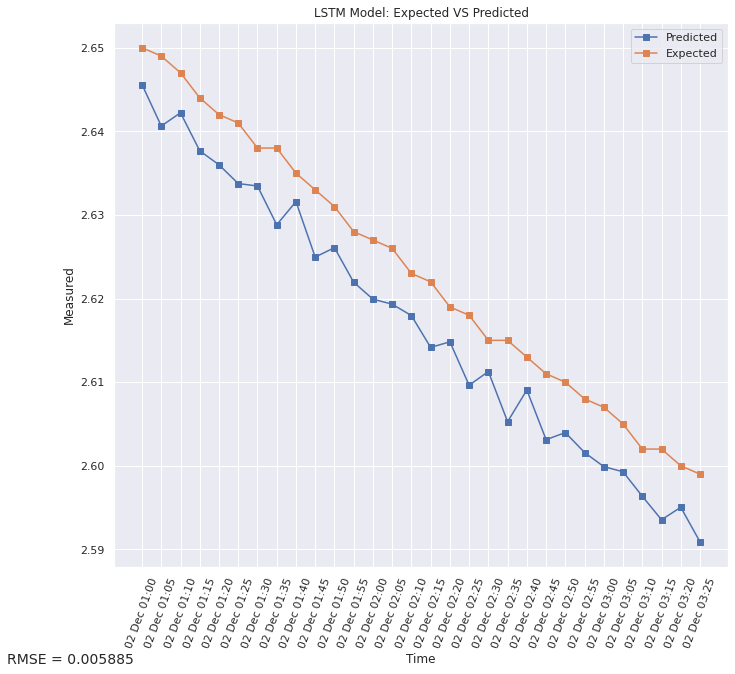

In [23]:
# Plot [start, end] interval
## 0 ~ 11824
start = 300
end = 330
plot_predicted_vs_expected(results["predicted"], results["expected"], results["overall_score"], data.index, start, end)

## Scatter Plot

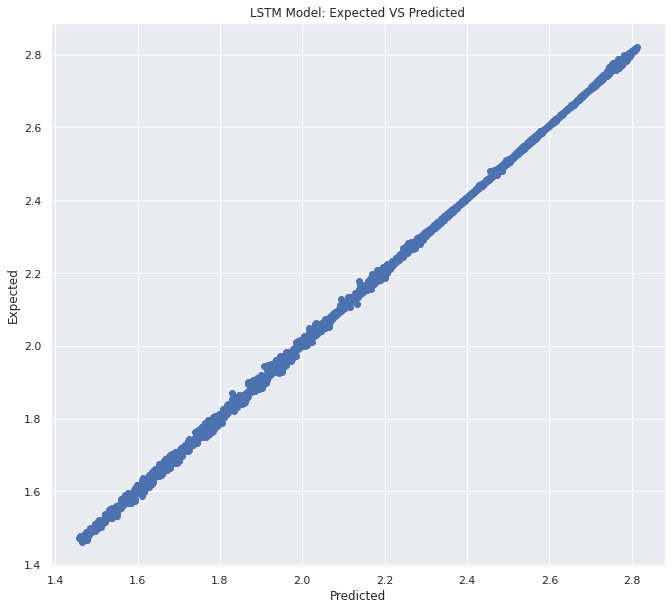

In [24]:
start = 0
end = -1
scatter_plot(results["predicted"], results["expected"], start, end)

## Main - Classification

### 1) Spikes | S

In [25]:
# Read "Spike" data
anomaly_type = "s"
s_data = read_anomaly_data(anomaly_type, "csvs/test_set")

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], s_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)


Limit: 0.02378

Spike (S):

  General:
    - TP: 2956
    - TN: 8868
    - FP: 0
    - FN: 0
    - Hits: 11824
    - Misses: 0
    - Total (hits + misses): 11824

  Metrics:
    - Accuracy: 100.0%
    - Precision: 100.0%
    - Recall: 100.0%
    - F1-Score: 100.0%


The classification hit all the predictions




### 2) Stationary Values | SV


Limit: 0.02378

Stationary Value (SV):

  General:
    - TP: 4
    - TN: 9331
    - FP: 0
    - FN: 2489
    - Hits: 9335
    - Misses: 2489
    - Total (hits + misses): 11824

  Metrics:
    - Accuracy: 78.95%
    - Precision: 100.0%
    - Recall: 0.1604%
    - F1-Score: 0.3204%


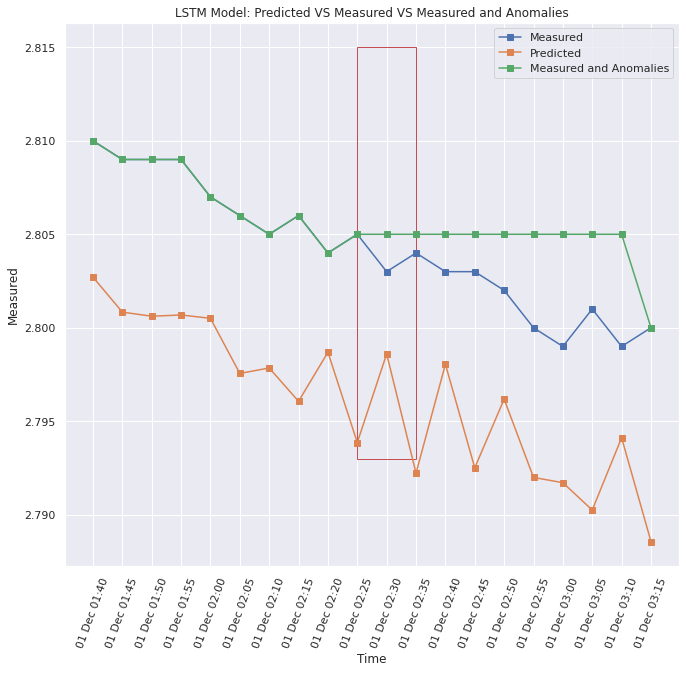

In [26]:
# Read "Stationary Values" data
anomaly_type = "sv"
sv_data = read_anomaly_data(anomaly_type, "csvs/test_set")

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], sv_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

### 3) Sensor Displacement | SD

In [27]:
# Read "Sensor Displacement" data
anomaly_type = "sd"
sd_data = read_anomaly_data(anomaly_type, "csvs/test_set")

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], sd_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)


Limit: 0.02378

Sensor Displacement (SD):

  General:
    - TP: 2956
    - TN: 8868
    - FP: 0
    - FN: 0
    - Hits: 11824
    - Misses: 0
    - Total (hits + misses): 11824

  Metrics:
    - Accuracy: 100.0%
    - Precision: 100.0%
    - Recall: 100.0%
    - F1-Score: 100.0%


The classification hit all the predictions




## 4) S + SV


Limit: 0.02378

Spike (S) and Stationary Value (SV):

  General:
    - TP: 451
    - TN: 9262
    - FP: 0
    - FN: 2111
    - Hits: 9713
    - Misses: 2111
    - Total (hits + misses): 11824

  Metrics:
    - Accuracy: 82.15%
    - Precision: 100.0%
    - Recall: 17.6%
    - F1-Score: 29.94%


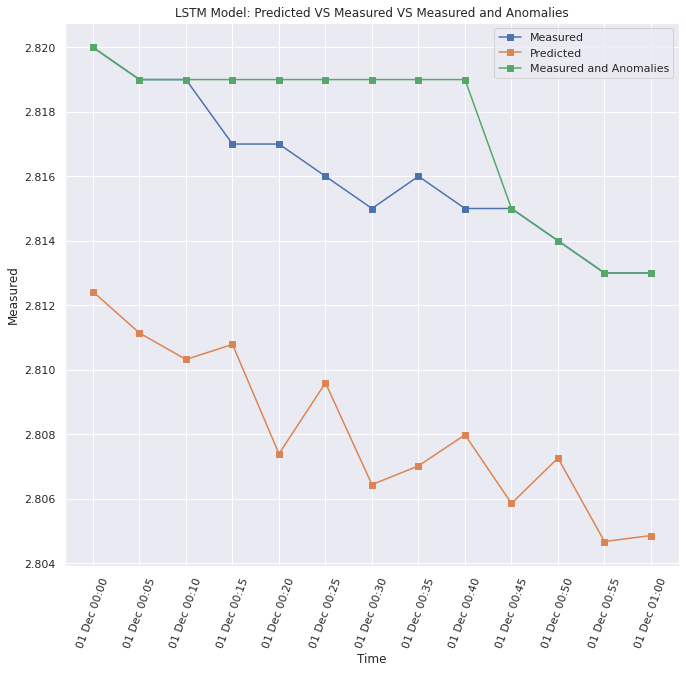

In [28]:
# Read "Spike + Stationary Values" data
anomaly_type = "s+sv"
s_sv_data = read_anomaly_data(anomaly_type, "csvs/test_set")

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], s_sv_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

## 5) S + SD

In [29]:
# Read "Spike + Sensor Displacement" data
anomaly_type = "s+sd"
s_sd_data = read_anomaly_data(anomaly_type, "csvs/test_set")

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], s_sd_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)


Limit: 0.02378

Spike (S) and Sensor Displacement (SD):

  General:
    - TP: 2956
    - TN: 8868
    - FP: 0
    - FN: 0
    - Hits: 11824
    - Misses: 0
    - Total (hits + misses): 11824

  Metrics:
    - Accuracy: 100.0%
    - Precision: 100.0%
    - Recall: 100.0%
    - F1-Score: 100.0%


The classification hit all the predictions




## 6) SV + SD


Limit: 0.02378

Stationary Value (SV) and Sensor Displacement (SD):

  General:
    - TP: 1606
    - TN: 9078
    - FP: 0
    - FN: 1140
    - Hits: 10684
    - Misses: 1140
    - Total (hits + misses): 11824

  Metrics:
    - Accuracy: 90.36%
    - Precision: 100.0%
    - Recall: 58.49%
    - F1-Score: 73.81%


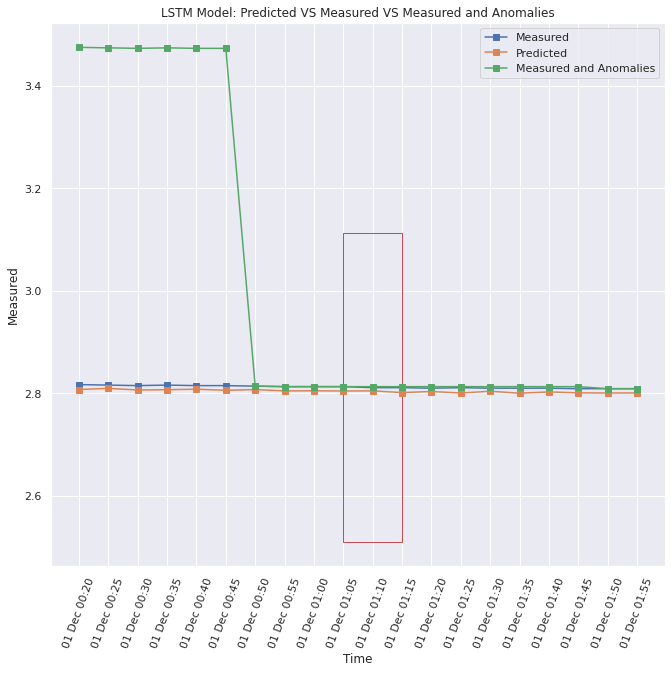

In [30]:
# Read "Stationary Values + Sensor Displacement" data
anomaly_type = "sv+sd"
sv_sd_data = read_anomaly_data(anomaly_type, "csvs/test_set")

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], sv_sd_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = np.mean(np.abs((results["expected"] - results["predicted"]) / results["expected"]))

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

## 7) S + SV + SD


Limit: 0.02378

Spike (S) and Stationary Value (SV) and Sensor Displacement (SD):

  General:
    - TP: 1498
    - TN: 9117
    - FP: 0
    - FN: 1209
    - Hits: 10615
    - Misses: 1209
    - Total (hits + misses): 11824

  Metrics:
    - Accuracy: 89.78%
    - Precision: 100.0%
    - Recall: 55.34%
    - F1-Score: 71.25%


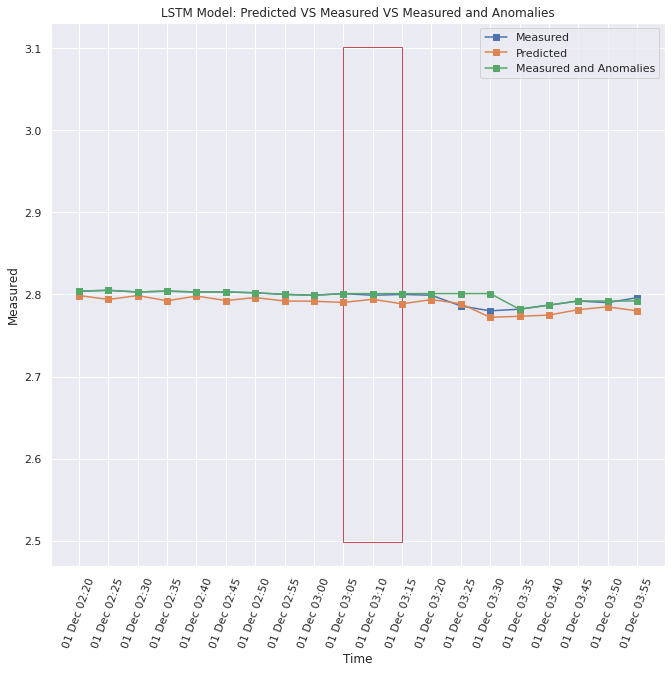

In [31]:
# Read "Spike + Stationary Values + Sensor Displacement" data
anomaly_type = "s+sv+sd"
s_sv_sd_data = read_anomaly_data(anomaly_type, "csvs/test_set")

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], s_sv_sd_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = np.mean(np.abs((results["expected"] - results["predicted"]) / results["expected"]))

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)